###Overview

This notebook creates the classification model. This is done by choosing the combination of class foreasting models that predicts the best classification score on the validation set. Here are the steps required for this:
1. We need to combine the **validation** sets of all classes to one big validation set used for classification evaluation.
2. We combine the **test** sets of all classes to one big test set used for final classification evaluation.
3. Define the evaluation class. This class receives a model and a set of samples for evaluation. It passes the samples through the model to receive predictions and evaluate the error of the trajectory. There are several options for the evaluation period. This period is also optimized on the validation set.
4. We load all the pandas dataframes that we have saved, containing all of the trained models paths and configurations. We combine to a unified dataframe.
5. 'get_validation_evaluation' - We want to compare the combinations of models using their errors to determine the classification. The comparison is done on the basis of a specific duration, say for a duration of 10 sec. We want to calculate the errors once and so we prepare a dictionary which saves the errors on all the 10 seconds samples from the validation set. The results are saved per model path.
6. 'get_best_combination' - We go through all combinations of models with one representitive per class. For each combination, we use the error of each model per sample to classify it. We obtain all the predictions and calculate the classification scores using the labels. We save the combination with the best f1-score for the UAV class.
7. Execute optimization for the best evaluation period for the chosen sample length to optimize. In the report we show different optimizations for 5 second samples vs. 30 second samples.
8. Using the best combination, do:\
  a. Final evaluation of errors for the class forecasting models on the test set. This is done for all sample durations.\
  b. Final classification using the errors of each class model.\
  c. Calculate performance (precision, recall, F1-score), using the class labels.\
  d. Show the metrics and confusion matrix for each duration.\
  e. Show bar plot with values

###Imports

In [ ]:
!pip install "pandas<2"

In [ ]:
# imports

import io
import glob
import os
import sys
from datetime import datetime
from time import time
import pickle
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import copy
import json
import matplotlib.pyplot as plt
import numpy as np
# from scipy.fft import fft
import pandas as pd
from itertools import product
import seaborn as sns
import random

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score

# torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
from torch.nn import Sigmoid,ReLU
from torch.nn import Linear,Dropout
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor,Compose
from torch.optim import SparseAdam,Adam,Adagrad,SGD

!pip install einops
# from __future__ import annotations
from dataclasses import dataclass
from einops import rearrange, repeat, einsum

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

from google.colab import drive
drive.mount('/content/drive/')
# helper files
sys.path.append('/content/drive/MyDrive/Final Project UAV/')
from UAV_project_preprocessing_and_visualization_helper_functions_full import *
from mamba_model import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 697.9 kB/s eta 0:00:00
Mounted at /content/drive/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Final Project UAV/

/content/drive/MyDrive/Final Project UAV


In [ ]:
subfolders = os.listdir("track_data/")
subf_dict = {i:subfolders[i] for i in range(len(subfolders))}
labels_dict = {subfolders[i]:i for i in range(len(subfolders))}

###Preparing test and validation samples

In [ ]:
# Here we combine the test samples from all different objects (subfolders)
# Each sample duration is combined separately so that we can evaluate separately for each duration
# The model returns the error averaged over the evaluation period

subfolders = ['airplane', 'uav', 'bird', 'static-object']
skips = [15, 15, 2, 40]
durations = [5, 10, 15, 20, 25, 30]
batch_size = 16

all_test_batches = {d:[] for d in durations}
all_test_labels = {d:[] for d in durations}
all_val_batches = {d:[] for d in durations}
all_val_labels = {d:[] for d in durations}
for subfolder, skip in zip(subfolders, skips):
  save_path = './Samples/mamba_samples_' + subfolder +'_skip'+ str(skip) +'_split0.2'+ '_all_samples'
  with open(save_path , 'rb') as f:
    (subfolder_train_data, subfolder_val_data, subfolder_test_data) = pickle.load(f)
    for dur, (samples, samples_filenames, dt, scales) in subfolder_test_data.items():
      if len(samples) > 0:
        subfolder_batches = []
        subfolder_labels = []
        dur_vec = [dur]*len(samples)
        data = list(zip(samples, dt, scales, dur_vec))

        dl = DataLoader(data, batch_size = batch_size, shuffle = False)
        for batch in dl:
          subfolder_batches.append(batch)

        # Note that the batches are not full so the labels are added as the original number of samples and not based on the number of batches
        subfolder_labels.extend([labels_dict[subfolder]] * len(samples))
        all_test_batches[dur].extend(subfolder_batches)
        all_test_labels[dur].extend(subfolder_labels)


    for dur, (samples, samples_filenames, dt, scales) in subfolder_val_data.items():
      if len(samples) > 0:
        subfolder_batches = []
        subfolder_labels = []
        dur_vec = [dur]*len(samples)
        data = list(zip(samples, dt, scales, dur_vec))

        dl = DataLoader(data, batch_size = batch_size, shuffle = False)
        for batch in dl:
          subfolder_batches.append(batch)

        # Note that the batches are not full so the labels are added as the original number of samples and not based on the number of batches
        subfolder_labels.extend([labels_dict[subfolder]] * len(samples))
        all_val_batches[dur].extend(subfolder_batches)
        all_val_labels[dur].extend(subfolder_labels)

###Evaluation class

In [ ]:
class Evaluating(object):

  def __init__(self, model, config):
    self.config = config
    self.device = config['device']
    self.model = model.to(self.device)
    self.criterion = nn.MSELoss(reduction='none').to(self.device)
    self.evaluation_start = int(config['evaluation_start']/config['delta'])
    self.evaluation_durations = config['evaluation_durations']

  def evaluate(self, dl_eval):
    self.eval_results = {d:[] for d in self.evaluation_durations}
    self.epoch_eval_loss = 0

    self.model.eval() #evaluation mode
    with torch.no_grad():
      for batch in tqdm(dl_eval, disable=True):
        self.eval_batch(batch)

  def eval_batch(self, batch):
    data, dt, scale, dur = batch
    # Send tensors to GPU
    samples = data[:,:-1,:]
    labels = data[:,1:,:]
    samples = samples.to(self.device)
    labels = labels.to(self.device)
    dt = dt[:, :-1].to(self.device)
    scale = scale.to(self.device)

    predictions = self.model(samples, dt)#.type(torch.float64)#.type(torch.DoubleTensor)

    scaled_labels = einsum(labels, 1/scale, 'b l d, b d -> b l d')
    scaled_predictions = einsum(predictions, 1/scale, 'b l d, b d -> b l d')
    eval_loss = self.criterion(scaled_predictions, scaled_labels)
    self.eval_results[int(dur[0])].extend(list((eval_loss[:, self.evaluation_start:, :].mean((1,2))).cpu())) #for fixed start
    # self.eval_results[int(dur[0])].extend(list((eval_loss[:, -self.evaluation_length:, :].mean((1,2))).cpu())) #for fixed end

    self.epoch_eval_loss += eval_loss.mean().item()

### Loading the information saved on all trained models

In [ ]:
field = 'Best Result @10'

In [ ]:
subfolders = ['airplane', 'uav', 'bird', 'static-object']
all_results_df = pd.DataFrame()
for subfolder in subfolders:
  prefix = './Mamba Training Results/mamba_training_results_split0.2_' + subfolder
  folder_results_df = pd.DataFrame()
  for file in glob.glob(prefix + '*'):
    print(file)
    with open(file, 'rb') as f:
      folder_results_df = folder_results_df.append(pickle.load(f))
  folder_results_df['Object'] = subfolder
  # best_model_row = folder_results_df.loc[folder_results_df['Best Result @5'].idxmin()]
  # all_results_df = all_results_df.append(best_model_row)
  all_results_df = all_results_df.append(folder_results_df)
  all_results_df = all_results_df.drop_duplicates(field)
best_models = all_results_df.groupby('Object').apply(lambda x: x[x[field] == x[field].min()])
saved_models_path = best_models[['Object', 'Model Path']].set_index('Object').to_dict()['Model Path']

./Mamba Training Results/mamba_training_results_split0.2_airplane04_04_2024, 10:17:14
./Mamba Training Results/mamba_training_results_split0.2_airplane04_10_2024, 16:08:04
./Mamba Training Results/mamba_training_results_split0.2_airplane04_10_2024, 16:51:44
./Mamba Training Results/mamba_training_results_split0.2_airplane05_11_2024, 12:27:26
./Mamba Training Results/mamba_training_results_split0.2_airplane05_11_2024, 12:38:43
./Mamba Training Results/mamba_training_results_split0.2_uav04_04_2024, 11:45:41
./Mamba Training Results/mamba_training_results_split0.2_uav04_11_2024, 04:57:09
./Mamba Training Results/mamba_training_results_split0.2_uav05_11_2024, 08:16:04
./Mamba Training Results/mamba_training_results_split0.2_uav05_11_2024, 09:57:51
./Mamba Training Results/mamba_training_results_split0.2_bird04_04_2024, 07:58:22
./Mamba Training Results/mamba_training_results_split0.2_bird04_04_2024, 08:32:41
./Mamba Training Results/mamba_training_results_split0.2_static-object04_04_2024, 

In [ ]:
all_results_df

,datetime,Best Result @5,Best Result @10,Best Result @20,Learning Rate,Batch Size,Layers,d_state,Model Path,Test Files,Mamba Config,Training Config,Train Loss History,Evaluation Loss History,Eval History,Best Results,Object
0,"04/04/2024, 09:56:52",560425,203240,235425,0.050,32,2,16,./Models/mamba_model_airplane_dm8nl2ds16dc4rs4...,[VIS_airplane_20231023-6210_20231023-162937.js...,"{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4225843.947368421, 3766551.3799342103, 336935...","[1372629.9775015025, 1187492.4270770734, 10263...","{5: [tensor(2009134.6250), tensor(1775395.), t...","{5: tensor(560425.7500), 10: tensor(203240.312...",airplane
1,"04/04/2024, 10:17:14",282335,195828,248199,0.010,64,1,16,./Models/mamba_model_airplane_dm8nl1ds16dc4rs4...,[VIS_airplane_20231023-6210_20231023-162937.js...,"{'d_model': 8, 'n_layer': 1, 'd_state': 16, 'e...","{'batch_size': 64, 'optimizer_type': <class 't...","[4246248.975, 3992137.15, 3741896.675, 3525284...","[1238016.1964285714, 1145974.049107143, 104862...","{5: [tensor(802754.0625), tensor(749276.8750),...","{5: tensor(282335.8750), 10: tensor(195828.203...",airplane
0,"04/10/2024, 16:08:04",214050,195370,349666,0.005,32,1,16,./Models/mamba_model_airplane_dm8nl1ds16dc4rs4...,[VIS_airplane_20231023-6210_20231023-162937.js...,"{'d_model': 8, 'n_layer': 1, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4600246.146381579, 4172647.755756579, 3780432...","[1243113.1310471755, 1094469.6147273136, 96192...","{5: [tensor(1044193.0625), tensor(932709.3125)...","{5: tensor(214050.9531), 10: tensor(195370.062...",airplane
1,"04/10/2024, 16:51:44",25951,24926,25643,0.010,32,2,16,./Models/mamba_model_airplane_dm8nl2ds16dc4rs4...,[VIS_airplane_20231023-6210_20231023-162937.js...,"{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4167401.966282895, 3774465.2976973685, 342633...","[1156171.3317307692, 1002759.4519230769, 87645...","{5: [tensor(966874.6875), tensor(850389.), ten...","{5: tensor(25951.9375), 10: tensor(24926.3535)...",airplane
0,"05/11/2024, 12:27:26",251889,206321,353713,0.050,32,1,32,./Models/mamba_model_airplane_dm8nl1ds32dc4rs4...,[VIS_airplane_20231023-6210_20231023-162937.js...,"{'d_model': 8, 'n_layer': 1, 'd_state': 32, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4482801.40131579, 4030353.052631579, 3608927....","[1818064.764423077, 1547408.173076923, 1313323...","{5: [tensor(1908564.8750), tensor(1626443.), t...","{5: tensor(251889.8750), 10: tensor(206321.296...",airplane
1,"05/11/2024, 12:38:43",571493,200991,238842,0.010,32,2,32,./Models/mamba_model_airplane_dm8nl2ds32dc4rs4...,[VIS_airplane_20231023-6210_20231023-162937.js...,"{'d_model': 8, 'n_layer': 2, 'd_state': 32, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4488925.62993421, 4086691.200657895, 3702856....","[1419282.0212965745, 1252783.6535268931, 11013...","{5: [tensor(2104463.2500), tensor(1890390.), t...","{5: tensor(571493.3125), 10: tensor(200991.500...",airplane
0,"04/04/2024, 11:45:41",40271,33698,48598,0.010,32,1,16,./Models/mamba_model_uav_dm8nl1ds16dc4rs42bs32...,"[VIS_uav_20231027-10807_20231027-113911.json, ...","{'d_model': 8, 'n_layer': 1, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4814974.322916667, 4483031.84375, 4158378.135...","[4517158.426470588, 4206336.134191177, 3909674...","{5: [tensor(4828341.5000), tensor(4496202.), t...","{5: tensor(40271.0977), 10: tensor(33698.7148)...",uav
0,"04/11/2024, 04:57:09",3040,1931,3640,0.010,32,2,16,./Models/mamba_model_uav_dm8nl2ds16dc4rs42bs32...,"[VIS_uav_20231027-10807_20231027-113911.json, ...","{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4395118.354166667, 3713927.0520833335, 311597...","[4172366.2959558824, 3538994.6727941176, 29729...","{5: [tensor(4344296.), tensor(3685911.), tenso...","{

In [ ]:
best_models

,,datetime,Best Result @5,Best Result @10,Best Result @20,Learning Rate,Batch Size,Layers,d_state,Model Path,Test Files,Mamba Config,Training Config,Train Loss History,Evaluation Loss History,Eval History,Best Results,Object
Object,,,,,,,,,,,,,,,,,,
airplane,1,"04/10/2024, 16:51:44",25951,24926,25643,0.01,32,2,16,./Models/mamba_model_airplane_dm8nl2ds16dc4rs4...,[VIS_airplane_20231023-6210_20231023-162937.js...,"{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4167401.966282895, 3774465.2976973685, 342633...","[1156171.3317307692, 1002759.4519230769, 87645...","{5: [tensor(966874.6875), tensor(850389.), ten...","{5: tensor(25951.9375), 10: tensor(24926.3535)...",airplane
bird,0,"04/04/2024, 07:58:22",2009,894,1236,0.05,32,2,16,./Models/mamba_model_bird_dm8nl2ds16dc4rs42bs3...,"[VIS_bird_20231116-20636_20231116-082324.json,...","{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[291574.09801136365, 255982.78941761365, 22666...","[229681.61830357142, 198624.72433035713, 17256...","{5: [tensor(206164.3125), tensor(178804.3281),...","{5: tensor(2009.7250), 10: tensor(894.1389), 1...",bird
static-object,0,"04/11/2024, 10:15:52",19819,23948,7809,0.01,32,2,16,./Models/mamba_model_static-object_dm8nl2ds16d...,[NIR_static-object_20231024-48984_20231024-234...,"{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[13983462.18939394, 12031126.984848484, 103617...","[6284997.214285715, 5050981.761904762, 4145497...","{5: [tensor(9513625.), tensor(7972746.), tenso...","{5: tensor(19819.8145), 10: tensor(23948.6816)...",static-object
uav,0,"04/11/2024, 04:57:09",3040,1931,3640,0.01,32,2,16,./Models/mamba_model_uav_dm8nl2ds16dc4rs42bs32...,"[VIS_uav_20231027-10807_20231027-113911.json, ...","{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4395118.354166667, 3713927.0520833335, 311597...","[4172366.2959558824, 3538994.6727941176, 29729...","{5: [tensor(4344296.), tensor(3685911.), tenso...","{5: tensor(3040.7278), 10: tensor(1931.6913), ...",uav


####Evaluating all models on the validation set with the chosen duration

In [ ]:
def get_validation_evaluation(all_results_df, all_val_batches, eval_dur, evaluation_config):
  validation_results = {}
  for i, row in all_results_df.iterrows():
    # print(row['Model Path'])
    # print(row['Mamba Config'])
    model_path = row['Model Path']
    state = torch.load(model_path, map_location=torch.device('cpu'))

    mamba_config = row['Mamba Config']
    args = ModelArgs(mamba_config['d_model'], mamba_config['n_layer'], mamba_config['d_state'], mamba_config['expand'], mamba_config['d_conv'])
    mamba_model = Mamba(args)

    mamba_model.load_state_dict(state['state_dict'])

    evaluating_mamba = Evaluating(mamba_model, evaluation_config)
    evaluating_mamba.evaluate(all_val_batches[eval_dur])

    validation_results[model_path] = evaluating_mamba.eval_results
  return validation_results

In [ ]:
# checking function
eval_dur = 10
evaluation_config = {'batch_size': 32, 'device' : device, 'evaluation_start': 0.5, 'delta': 0.04, 'evaluation_durations': durations}
validation_results = get_validation_evaluation(all_results_df, all_val_batches, eval_dur, evaluation_config)

####Evaluate combinations of models
Get the best combination for UAV f1-score

In [ ]:
object_paths = all_results_df.groupby('Object')['Model Path'].apply(list)

In [ ]:
def get_best_combination(validation_results, eval_dur, all_val_labels, object_paths):
  #We go through all combinations of models with one representitive per class.
  #For each combination, we use the error of each model per sample to classify it.
  #We obtain all the predictions and calculate the classification scores using the labels.
  #We save the combination with the best f1-score for the UAV class.
  dur_labels = all_val_labels[eval_dur]
  best_uav_f1 = 0
  best_comb = None
  for a,b,c,d in product (object_paths['airplane'], object_paths['uav'], object_paths['bird'], object_paths['static-object']):
    # print(validation_results[a][eval_dur])
    errors = torch.stack((torch.tensor(validation_results[a][eval_dur]), torch.tensor(validation_results[b][eval_dur]), torch.tensor(validation_results[c][eval_dur]), torch.tensor(validation_results[d][eval_dur])))
    predicted_class = torch.argmin(errors, dim=0)
    report = classification_report(dur_labels, predicted_class, target_names=subfolders, output_dict = True)
    uav_f1 = report['uav']['f1-score']
    # print(uav_f1)
    if uav_f1 > best_uav_f1:
      best_uav_f1 = uav_f1
      best_comb = (a,b,c,d)
  return best_uav_f1, best_comb


In [ ]:
# We can optimize the combination to a specific sample duration and the evaluation period.
# We are free to optimize on the validation set.
# This block finds the best combination for the specified sample length (eval_dur)

eval_dur = 30
eval_start_at = [3]
best_eval_start = None
all_best_uav_f1 = 0
all_best_comb = None
for eval_start in eval_start_at:
  evaluation_config = {'batch_size': 32, 'device' : device, 'evaluation_start': eval_start, 'delta': 0.04, 'evaluation_durations': durations}
  validation_results = get_validation_evaluation(all_results_df, all_val_batches, eval_dur, evaluation_config)
  best_uav_f1, best_comb = get_best_combination(validation_results, eval_dur, all_val_labels, object_paths)
  if best_uav_f1 > all_best_uav_f1:
    all_best_uav_f1 = best_uav_f1
    all_best_comb = best_comb
    best_eval_start = eval_start
  print(eval_start,':', best_uav_f1)

3 : 0.8943089430894309


In [ ]:
best_eval_start

0.5

In [ ]:
all_best_comb

('./Models/mamba_model_airplane_dm8nl1ds16dc4rs42bs32opAdamlr0.005r104_10_2024, 16:08:04',
 './Models/mamba_model_uav_dm8nl1ds16dc4rs42bs32opAdamlr0.01r104_04_2024, 11:45:41',
 './Models/mamba_model_bird_dm8nl2ds16dc4rs42bs32opAdamlr0.05r104_04_2024, 07:58:22',
 './Models/mamba_model_static-object_dm8nl1ds16dc4rs42bs32opAdamlr0.01r104_04_2024, 13:50:05')

Evaluate using the best combination on the test data

In [ ]:
# Final evaluation on the test set
# First we calculate the error per sample for each one of the models in the chosen combination, for all durations
durations =[5, 10, 15, 20, 25, 30]
evaluation_config = {'batch_size': 32, 'device' : device, 'evaluation_start': best_eval_start, 'delta': 0.04, 'evaluation_durations': durations}
flying_objects = ['airplane', 'uav', 'bird', 'static-object']
evaluation_results = {}

for f_object, model_path in zip(flying_objects, all_best_comb):
  state = torch.load(model_path, map_location=torch.device('cpu'))
  mamba_config = all_results_df.loc[all_results_df['Model Path'] == model_path]['Mamba Config'].values[0]
  args = ModelArgs(mamba_config['d_model'], mamba_config['n_layer'], mamba_config['d_state'], mamba_config['expand'], mamba_config['d_conv'])
  mamba_model = Mamba(args)

  mamba_model.load_state_dict(state['state_dict'])

  evaluating_mamba = Evaluating(mamba_model, evaluation_config)
  all = []
  for dur in durations:
    # all.extend(all_test_batches[dur])
    all.extend(all_test_batches[dur])

  evaluating_mamba.evaluate(all)
  evaluation_results[f_object] = evaluating_mamba.eval_results

###Classification evaluation

In [ ]:
# subf_dict = {i:subfolders[i] for i in range(len(subfolders))}
# labels_dict = {subfolders[i]:i for i in range(len(subfolders))}

Results for sample duration of 5 sec
{'airplane': {'precision': 0.9285714285714286, 'recall': 0.22033898305084745, 'f1-score': 0.3561643835616438, 'support': 59}, 'uav': {'precision': 0.8315789473684211, 'recall': 0.9518072289156626, 'f1-score': 0.8876404494382022, 'support': 83}, 'bird': {'precision': 0.6271186440677966, 'recall': 0.6379310344827587, 'f1-score': 0.6324786324786326, 'support': 58}, 'static-object': {'precision': 0.6814814814814815, 'recall': 0.8932038834951457, 'f1-score': 0.7731092436974789, 'support': 103}, 'accuracy': 0.7293729372937293, 'macro avg': {'precision': 0.767187625372282, 'recall': 0.6758202824861036, 'f1-score': 0.6623481772939893, 'support': 303}, 'weighted avg': {'precision': 0.7603044252997294, 'recall': 0.7293729372937293, 'f1-score': 0.696375804350194, 'support': 303}}


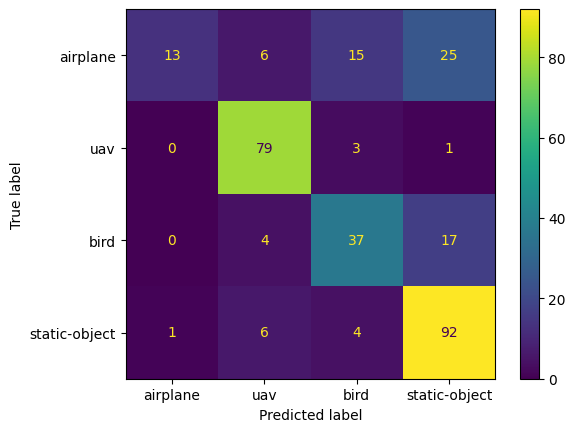

Results for sample duration of 10 sec
{'airplane': {'precision': 0.875, 'recall': 0.1346153846153846, 'f1-score': 0.23333333333333334, 'support': 52}, 'uav': {'precision': 0.8555555555555555, 'recall': 0.9506172839506173, 'f1-score': 0.9005847953216374, 'support': 81}, 'bird': {'precision': 0.5555555555555556, 'recall': 0.5813953488372093, 'f1-score': 0.5681818181818183, 'support': 43}, 'static-object': {'precision': 0.6791044776119403, 'recall': 0.900990099009901, 'f1-score': 0.774468085106383, 'support': 101}, 'accuracy': 0.7220216606498195, 'macro avg': {'precision': 0.741303897180763, 'recall': 0.641904529103278, 'f1-score': 0.619142007985793, 'support': 277}, 'weighted avg': {'precision': 0.7482976213996204, 'recall': 0.7220216606498195, 'f1-score': 0.6777393376604651, 'support': 277}}


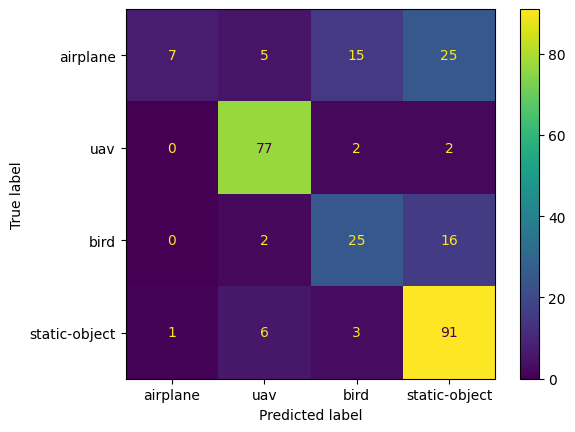

Results for sample duration of 15 sec
{'airplane': {'precision': 0.8571428571428571, 'recall': 0.15, 'f1-score': 0.2553191489361702, 'support': 40}, 'uav': {'precision': 0.8809523809523809, 'recall': 0.9487179487179487, 'f1-score': 0.9135802469135802, 'support': 78}, 'bird': {'precision': 0.45714285714285713, 'recall': 0.5161290322580645, 'f1-score': 0.4848484848484849, 'support': 31}, 'static-object': {'precision': 0.7333333333333333, 'recall': 0.9072164948453608, 'f1-score': 0.8110599078341014, 'support': 97}, 'accuracy': 0.7479674796747967, 'macro avg': {'precision': 0.7321428571428572, 'recall': 0.6305158689553435, 'f1-score': 0.6162019471330842, 'support': 246}, 'weighted avg': {'precision': 0.7654665118079752, 'recall': 0.7479674796747967, 'f1-score': 0.7120940622232396, 'support': 246}}


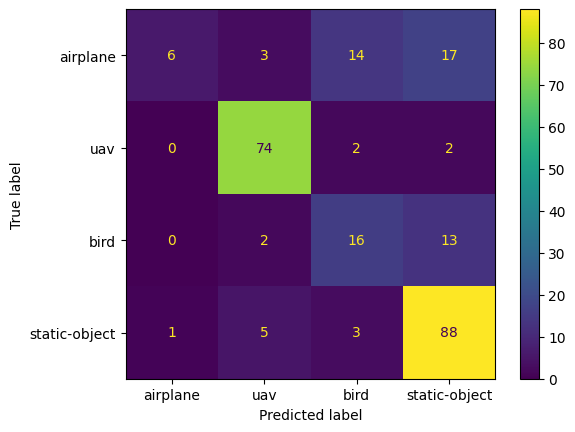

Results for sample duration of 20 sec
{'airplane': {'precision': 1.0, 'recall': 0.20588235294117646, 'f1-score': 0.34146341463414637, 'support': 34}, 'uav': {'precision': 0.9459459459459459, 'recall': 0.958904109589041, 'f1-score': 0.9523809523809523, 'support': 73}, 'bird': {'precision': 0.43333333333333335, 'recall': 0.5652173913043478, 'f1-score': 0.49056603773584906, 'support': 23}, 'static-object': {'precision': 0.7727272727272727, 'recall': 0.9340659340659341, 'f1-score': 0.845771144278607, 'support': 91}, 'accuracy': 0.7918552036199095, 'macro avg': {'precision': 0.7880016380016379, 'recall': 0.6660174469751248, 'f1-score': 0.6575453872573886, 'support': 221}, 'weighted avg': {'precision': 0.8295877942936766, 'recall': 0.7918552036199095, 'f1-score': 0.7664332969169605, 'support': 221}}


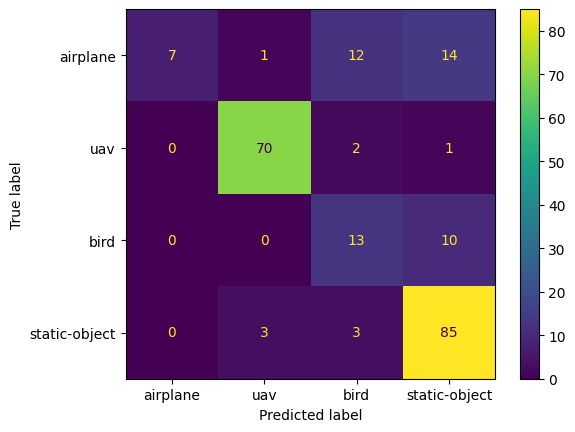

Results for sample duration of 25 sec
{'airplane': {'precision': 1.0, 'recall': 0.20689655172413793, 'f1-score': 0.34285714285714286, 'support': 29}, 'uav': {'precision': 0.9444444444444444, 'recall': 0.9577464788732394, 'f1-score': 0.951048951048951, 'support': 71}, 'bird': {'precision': 0.44, 'recall': 0.5789473684210527, 'f1-score': 0.5, 'support': 19}, 'static-object': {'precision': 0.7878787878787878, 'recall': 0.9397590361445783, 'f1-score': 0.8571428571428572, 'support': 83}, 'accuracy': 0.806930693069307, 'macro avg': {'precision': 0.793080808080808, 'recall': 0.6708373587907521, 'f1-score': 0.6627622377622377, 'support': 202}, 'weighted avg': {'precision': 0.8406410641064106, 'recall': 0.806930693069307, 'f1-score': 0.7827237119316327, 'support': 202}}


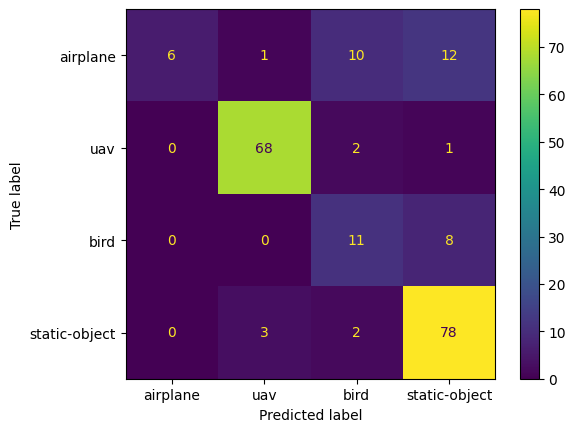

Results for sample duration of 30 sec
{'airplane': {'precision': 1.0, 'recall': 0.20833333333333334, 'f1-score': 0.3448275862068966, 'support': 24}, 'uav': {'precision': 0.9428571428571428, 'recall': 0.9705882352941176, 'f1-score': 0.9565217391304348, 'support': 68}, 'bird': {'precision': 0.391304347826087, 'recall': 0.6, 'f1-score': 0.47368421052631576, 'support': 15}, 'static-object': {'precision': 0.8372093023255814, 'recall': 0.935064935064935, 'f1-score': 0.8834355828220859, 'support': 77}, 'accuracy': 0.8260869565217391, 'macro avg': {'precision': 0.7928426982522029, 'recall': 0.6784966259230965, 'f1-score': 0.6646172796714332, 'support': 184}, 'weighted avg': {'precision': 0.8611356913627543, 'recall': 0.8260869565217391, 'f1-score': 0.806788822636035, 'support': 184}}


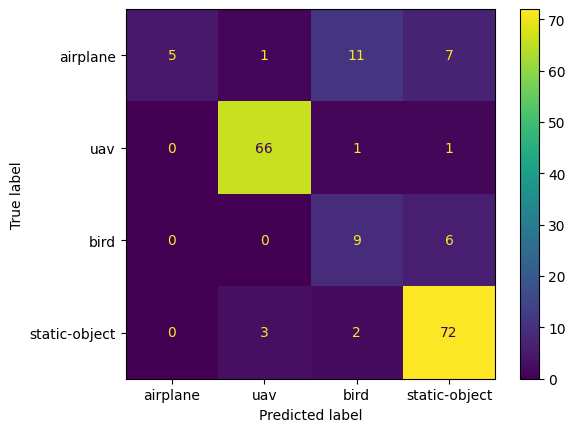

In [ ]:
# Execute final classification
# Show the classification scores and confusion matrix per sample duration
all_reports = {d:[] for d in durations}
for dur in durations:
  dur_labels = all_test_labels[dur]
  errors = torch.full((len(subf_dict.keys()), len(dur_labels)), torch.inf)
  for f_object, eval_results in evaluation_results.items():
    if len(eval_results[dur]) > 0:
      errors[labels_dict[f_object]] = torch.tensor(eval_results[dur])
  predicted_class = torch.argmin(errors, dim=0)
  report = classification_report(dur_labels, predicted_class, target_names=evaluation_results.keys(), output_dict = True)
  cm = confusion_matrix(dur_labels, predicted_class)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=flying_objects)
  # cm = confusion_matrix(dur_labels, predicted_class, labels=flying_objects)
  all_reports[dur] = report
  print(f'Results for sample duration of {dur} sec')
  print(report)
  disp.plot()
  plt.show()

In [ ]:
def plot_training_summary(train_loss_history, eval_loss_history, eval_history, evaluation_durations):
  epochs = np.arange(len(train_loss_history)) + 1
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4,5))
  fig.tight_layout()
  ax1.plot(epochs, train_loss_history, 'r', label = 'Training Loss')
  ax1.plot(epochs, eval_loss_history, 'orange', label = 'Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.legend()
  ax1.set_yscale("log")
  palette = plt.get_cmap('tab20')
  colors = [palette(i) for i in range(len(evaluation_durations))]
  for d, color in zip(evaluation_durations, colors):
    ax2.plot(epochs, eval_history[d], color = color, label = d)
  ax2.set_yscale("log")
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Error (by sample duration)')
  ax2.legend()

Results for airplane
Results for uav
Results for bird
Results for static-object


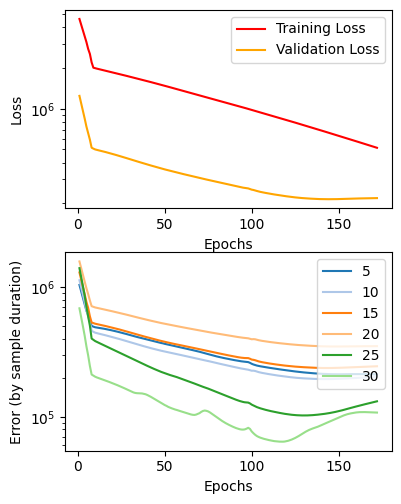

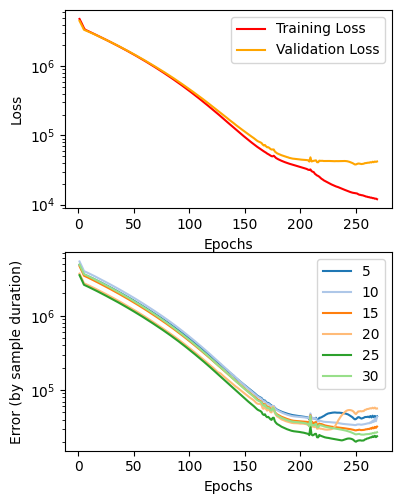

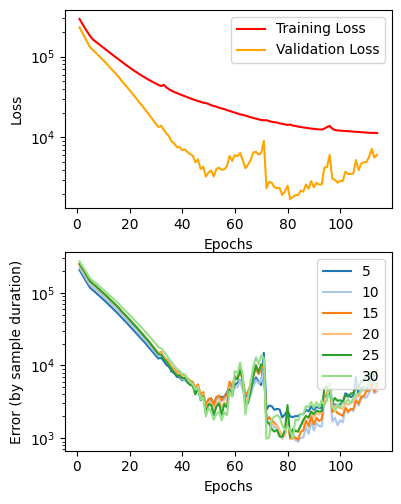

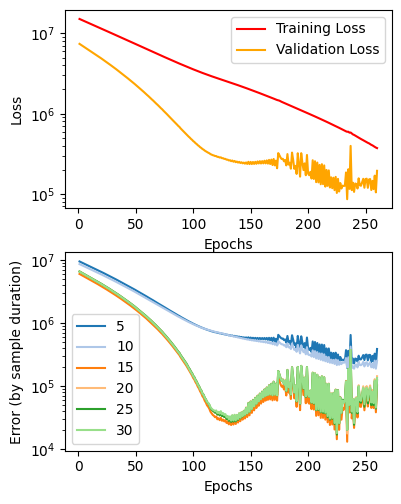

In [ ]:
evaluation_durations =[5, 10, 15, 20, 25, 30]
for f_object, model_path in zip(flying_objects, best_comb):
  train_loss_history = all_results_df[all_results_df['Model Path'] == model_path]['Train Loss History'].values[0]
  eval_loss_history = all_results_df[all_results_df['Model Path'] == model_path]['Evaluation Loss History'].values[0]
  eval_history = all_results_df[all_results_df['Model Path'] == model_path]['Eval History'].values[0]
  print(f'Results for {f_object}')
  plot_training_summary(train_loss_history, eval_loss_history, eval_history, evaluation_durations)

In [ ]:
# Form a dataframe with the results for a convenient graph presentation
summary_df = pd.DataFrame(columns = ['Duration', 'Metric', 'Score'])
for d, report in all_reports.items():
  summary_df.loc[len(summary_df)] = [d, 'precision', report['uav']['precision']]
  summary_df.loc[len(summary_df)] = [d,'recall', report['uav']['recall']]
  summary_df.loc[len(summary_df)] = [d,'f1-score', report['uav']['f1-score']]


In [ ]:
summary_df

,Duration,Metric,Score
0,5,precision,0.872340
1,5,recall,0.987952
2,5,f1-score,0.926554
3,10,precision,0.877778
4,10,recall,0.975309
5,10,f1-score,0.923977
6,15,precision,0.902439
7,15,recall,0.948718
8,15,f1-score,0.925000
9,20,precision,0.945946


Text(36.464534722222226, 0.5, 'Test Score')

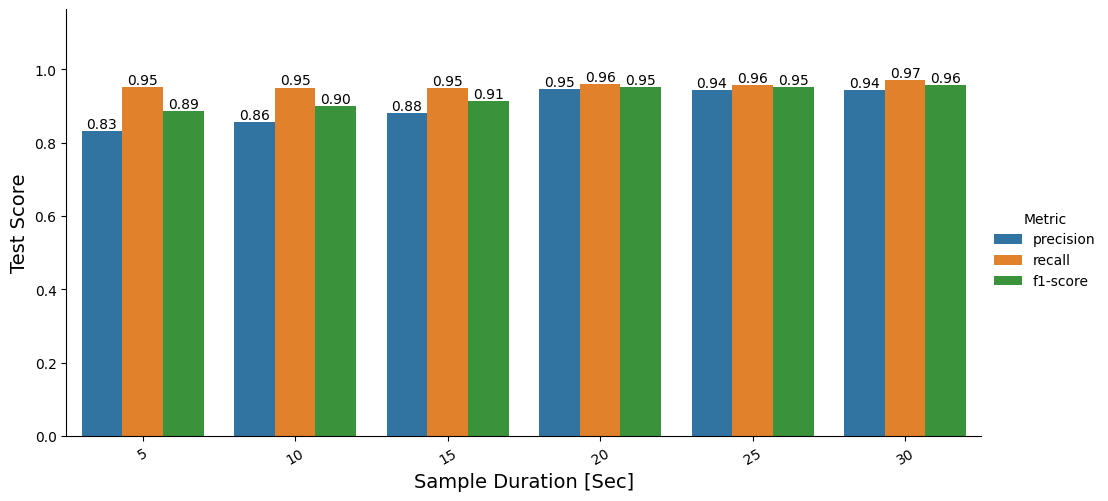

In [ ]:
# optimized for 30 sec
g = sns.catplot(data=summary_df, x = "Duration", y = "Score", hue = "Metric", kind="bar", aspect = 2)

for ax in g.axes.ravel():
    for c in ax.containers:
        labels = ['%0.2f' % v for v in c.datavalues]
        ax.bar_label(c, labels=labels, label_type='edge')
    # plt.xticks(rotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.margins(y=0.2)
plt.xlabel('Sample Duration [Sec]', fontsize=14)
plt.ylabel('Test Score', fontsize=14)

Text(36.464534722222226, 0.5, 'Test Score')

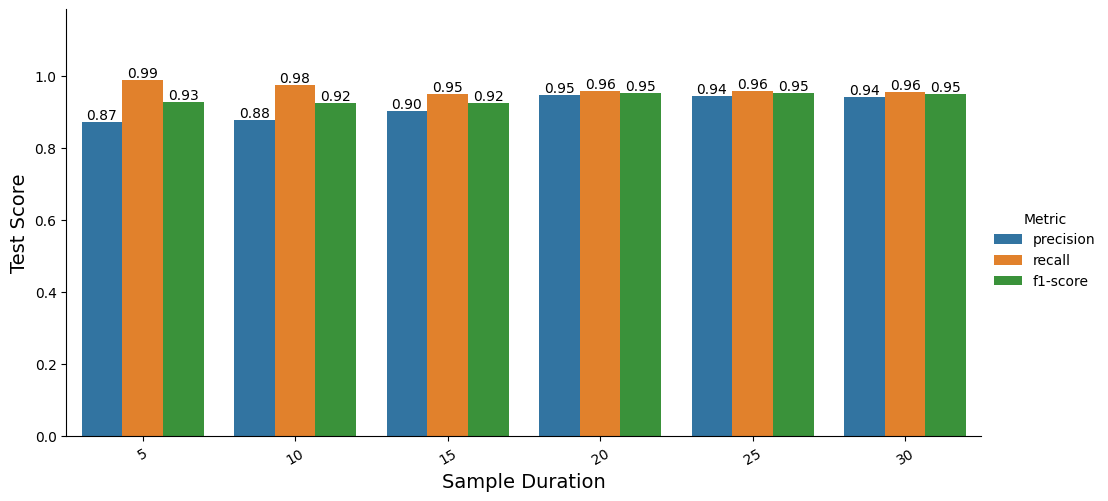

In [ ]:
# optimized for 5 sec
g = sns.catplot(data=summary_df, x = "Duration", y = "Score", hue = "Metric", kind="bar", aspect = 2)

for ax in g.axes.ravel():
    for c in ax.containers:
        labels = ['%0.2f' % v for v in c.datavalues]
        ax.bar_label(c, labels=labels, label_type='edge')
    # plt.xticks(rotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.margins(y=0.2)
plt.xlabel('Sample Duration', fontsize=14)
plt.ylabel('Test Score', fontsize=14)

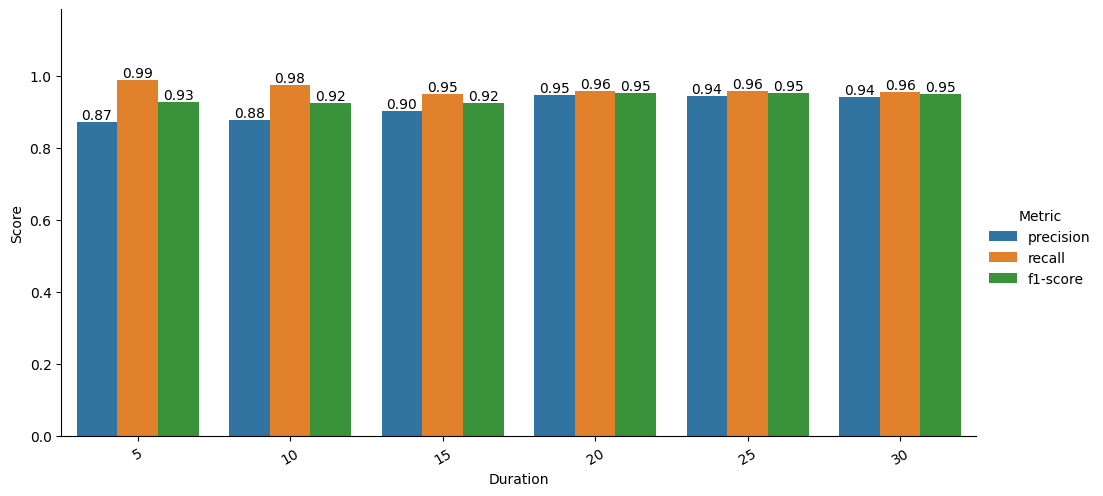

In [ ]:
# optimized for 10 sec
g = sns.catplot(data=summary_df, x = "Duration", y = "Score", hue = "Metric", kind="bar", aspect = 2)

for ax in g.axes.ravel():
    for c in ax.containers:
        labels = ['%0.2f' % v for v in c.datavalues]
        ax.bar_label(c, labels=labels, label_type='edge')
    # plt.xticks(rotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.margins(y=0.2)